# *CIS 545 Data Project*
This data project explores a Kaggle Dataset about Hateful Users on Twitter. After exploratory analysis (and visualizations), I have used sklearn to build classification models for identifying hateful users (using an Adaboost Decision Tree Classifier and SVC). GridSearchCV was used to tune the hyperparameters. Additionally I used clustering techniques (Hierarchial and K-means) to cluster users based on the empathy tags and gloVe values for their tweets. 

### Loading packages

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import nltk
nltk.download('punkt')
import networkx as nx
import pandas.util.testing as tm

from wordcloud import WordCloud
from pprint import pprint
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Loading data from Kaggle

In [3]:
## In case you need to load the dataset, all that will be required is for you 
## to obtain the token and key from your Kaggle account.
## I have removed mine prior to submitting this notebook

! pip install -q kaggle
! mkdir .kaggle
import json

## token =  {"username":"","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [4]:
!kaggle datasets download -d manoelribeiro/hateful-users-on-twitter -p /content
!unzip \*.zip

100% 1.62G/1.63G [00:17<00:00, 133MB/s]
100% 1.63G/1.63G [00:17<00:00, 100MB/s]
Archive:  hateful-users-on-twitter.zip
  inflating: users.edges             
  inflating: users_clean.graphml     
  inflating: users_hate_all.content  
  inflating: users_hate_glove.content  
  inflating: users_neighborhood_anon.csv  
  inflating: users_suspended_all.content  
  inflating: users_suspended_glove.content  


In [5]:
d = pd.read_csv('users_neighborhood_anon.csv')
print(d.shape)

(100386, 1039)


In [6]:
# pre-processing, dropping duplicates and NA values
d.drop_duplicates(inplace=True)
d.dropna(inplace=True)
d.shape

(92774, 1039)

After cleaning, the dataset contains information about 92774 users and has 1039  for each user

### User Graph

In [0]:
# user_neighbourhood = pd.read_csv('users.edges', sep=" ", header=None)
# print(user_neighbourhood.shape)

# annotated users_graph
# annotated_neighbourhood = user_neighbourhood.rename(columns={0: "from", 1:'to'})
# annotated_neighbourhood.head(5)

# user_neighbourhood.drop_duplicates(inplace=True)
# user_neighbourhood.dropna(inplace=True)
# user_neighbourhood.shape

### Making new dataframes based on user type

Here I have created 6 new dataframes:


*   annotated_users - contains users who were annotated as being hateful or normal. This dataset is used later for the ml models.
*   hateful_users - contains users annotated as hateful
*   normal_users - contains users annotated as normal
*   active_users - contains users who were active as of 12/12/17 or 14/01/18
*   deleted_users - contains users who were deleted as of 12/12/17 or 14/01/18
*   suspended_users - contains users who were suspended as of 12/12/17 or 14/01/18

These will be used for visualizations, to compare activity across different user types.








In [7]:
usr_type = ['hateful', 'normal']
annotated_users = d[d['hate'].isin(usr_type)]
print(annotated_users.shape)

(4659, 1039)


Creating a new df called **user_mean_df**.
This df contains information about the average values for users of different types for the columns:
`columns = ['in_degree', 'betweenness', 'eigenvector' , 'out_degree', 'subjectivity', 'sentiment', 'baddies']`


In [9]:
users = ['hateful', 'normal', 'active', 'suspended', 'deleted']
user_mean_df = pd.DataFrame({'user_type': users})

hateful_users = annotated_users[annotated_users['hate'] == 'hateful']
normal_users = annotated_users[annotated_users['hate'] == 'normal']
active_users = annotated_users[annotated_users['is_63_2'] == False]
active_users = active_users[active_users['is_50_2'] == False]
deleted_users = annotated_users[annotated_users['is_50_2'] == True]
suspended_users = annotated_users[annotated_users['is_63_2'] == True]

columns = ['in_degree', 'betweenness', 'eigenvector' , 'out_degree', 'subjectivity', 'sentiment', 'baddies']
for i in range(len(columns)):
    col = columns[i]
    l = [hateful_users[col].mean(), normal_users[col].mean(), active_users[col].mean(), \
         deleted_users[col].mean(),  suspended_users[col].mean()]
    user_mean_df[col] = l

user_mean_df

,user_type,in_degree,betweenness,eigenvector,out_degree,subjectivity,sentiment,baddies
0,hateful,0.000311,49086.143790,6.747925e-07,0.000160,0.474082,0.057900,32.826087
1,normal,0.000256,44465.717363,1.025824e-04,0.000102,0.502396,0.119668,24.250536
2,active,0.000261,45076.737363,9.405169e-05,0.000106,0.499691,0.114499,24.955051
3,suspended,0.000297,28191.276793,1.336102e-07,0.000123,0.534658,0.074071,36.750000
4,deleted,0.000261,37557.093111,2.158571e-07,0.000195,0.483331,0.053115,32.850000


### Visualizations 

**( In | Out ) Degree plots**

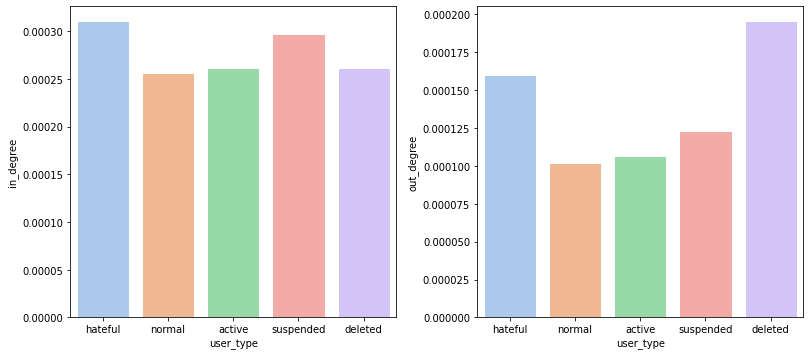

In [0]:
fig_dims =(12, 6)
fig, axs = plt.subplots(1,2, figsize=fig_dims)
fig.tight_layout(pad=5.0)

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.in_degree, palette="pastel", ax=axs[0])

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.out_degree, palette="pastel", ax=axs[1])

fig.show()

From the graphs above, we see  that hateful users have the highest average in degree, but it is not that different from the average indegree value of other user types.

On the other hand, deleted users have (in their case, had), the highest average out degree.

**Centrality plots**

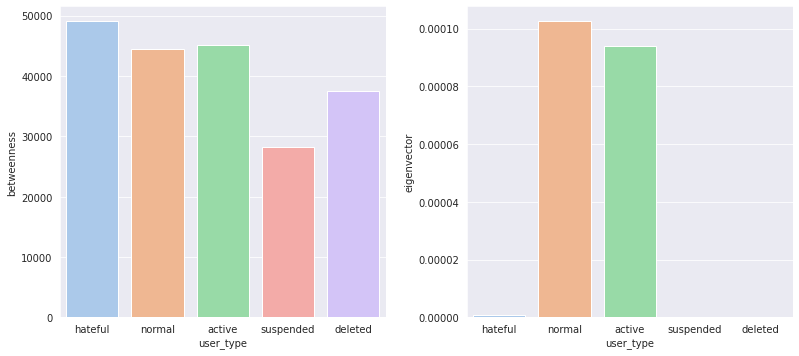

In [0]:
fig_dims =(12, 6)
fig, axs = plt.subplots(1,2, figsize=fig_dims)
fig.tight_layout(pad=5.0)

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.betweenness, palette="pastel", ax=axs[0])

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.eigenvector, palette="pastel", ax=axs[1])

fig.show()

The average betweeness seems to be more or less the same for different user types.

The average eigenvector plot, is where we see the most difference between user types. Eigenvector centrality measures the "influence" that a node has in a graph, and this would suggest that hateful users are not as influential as "normal" users  



**Tweet content related plots**

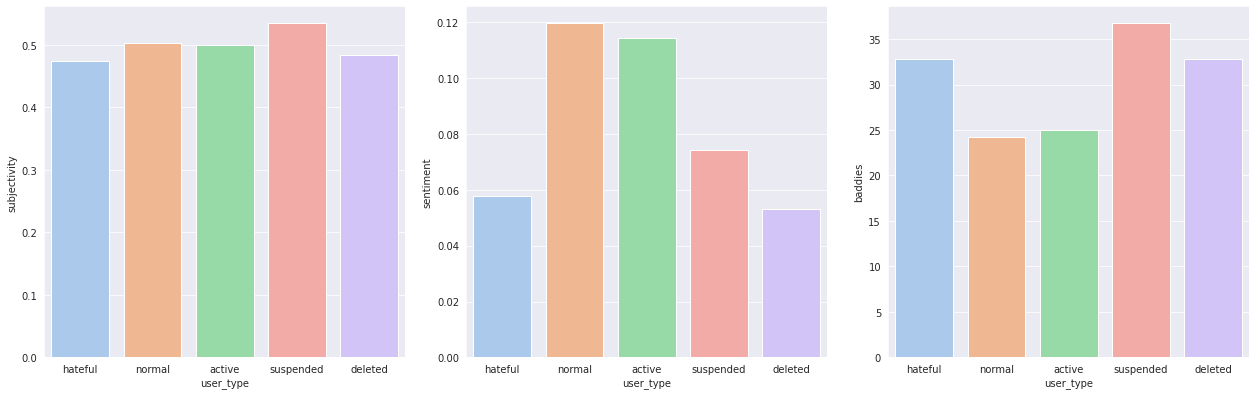

In [0]:
fig_dims =(18, 6)
fig, axs = plt.subplots(1,3, figsize=fig_dims)
fig.tight_layout(pad=3.0)

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.subjectivity, palette="pastel", ax=axs[0])

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.sentiment, palette="pastel", ax=axs[1])

sns.set_style("darkgrid")
sns.barplot(user_mean_df.user_type, user_mean_df.baddies, palette="pastel", ax=axs[2])

fig.show()

As expected, the most bad words were used by suspended users and deleted users, followed by hateful users. 

More surprisingly, the subjectivity is more or less the same across all user types.

**More indepth comparision of the distribution of normal versus hateful users**

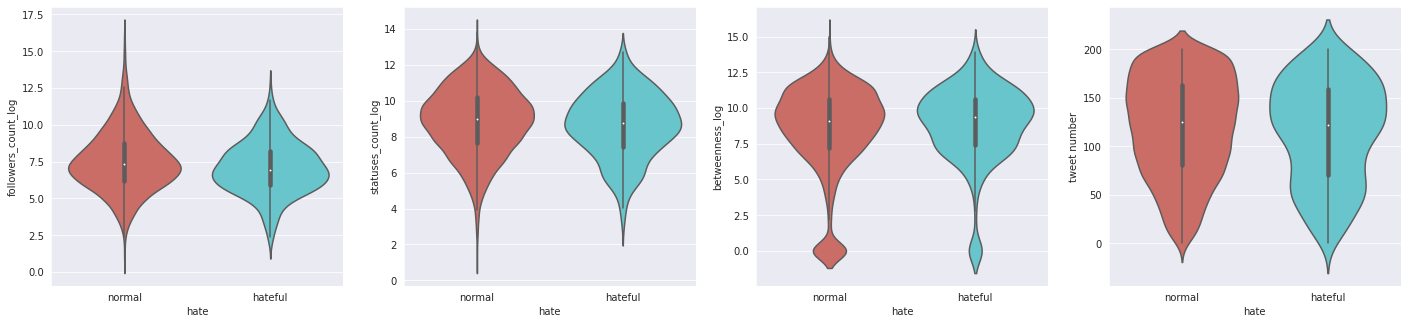

In [0]:
#violin plots
fig_dims =(20, 5)
fig, axs = plt.subplots(1,4, figsize=fig_dims)
fig.tight_layout(pad=3.0)
pd.options.mode.chained_assignment = None

sns.set_style("darkgrid")
cols = ['hate', 'followers_count', 'statuses_count', 'betweenness']
log_values = annotated_users[cols]
log_values['followers_count_log'] = np.log(log_values['followers_count'] + 1)
log_values['betweenness_log'] = np.log(log_values['betweenness'] + 1)
log_values['statuses_count_log'] = np.log(log_values['statuses_count'] + 1)

sns.violinplot(x='hate', y='followers_count_log', kind='violin', data=log_values, ax=axs[0], palette='hls')
sns.violinplot(x='hate', y='statuses_count_log', kind='violin', data=log_values, ax=axs[1], palette='hls')
sns.violinplot(x='hate', y='betweenness_log', kind='violin', data=log_values, ax=axs[2], palette='hls')
sns.violinplot(x='hate', y='tweet number', kind='violin', data=annotated_users, ax=axs[3], palette='hls')

fig.show()

Here, I wanted to look specifically at the normal versus hateful users as this is the crux of the machine learning problem. I have created violin plots from the log scaled values of follower_count, statuses_count and betweeness for hateful and normal users. We see the distributions are very similar.


normal mean sentiment 0.11966803783567921
hateful mean sentiment 0.0578998417779427


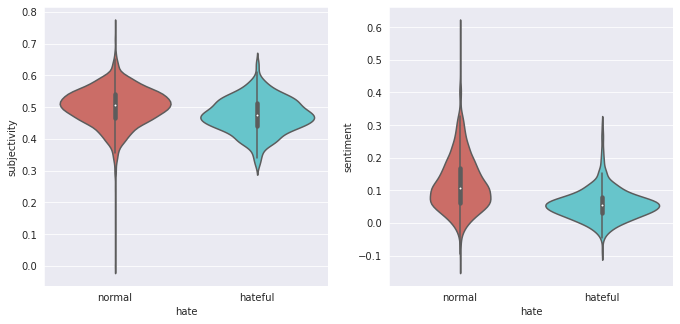

In [0]:
print("normal mean sentiment " + str(normal_users['sentiment'].mean()))
print("hateful mean sentiment " + str(hateful_users['sentiment'].mean()))

fig_dims =(10, 5)
fig, axs = plt.subplots(1,2, figsize=fig_dims)
fig.tight_layout(pad=3.0)

sns.set_style("darkgrid")
sns.violinplot(x='hate', y='subjectivity', kind='violin', data=annotated_users, palette='hls', ax=axs[0])
sns.violinplot(x='hate', y='sentiment', kind='violin', data=annotated_users, palette='hls', ax=axs[1])
fig.show()

# fig, ax =plt.subplots(1,2)
# sns.distplot(hateful_users['sentiment'], hist=True, kde=False, 
#              bins=int(50/5), color = 'green', ax=ax[0],
#              hist_kws={'edgecolor':'black'})
# sns.distplot(normal_users['sentiment'], hist=True, kde=False, 
#              bins=int(50/5), color = 'red', ax=ax[1],
#              hist_kws={'edgecolor':'black'})
# fig.show()

**Number of hateful neighbours and normal neighbours for normal vs hateful users**

In [0]:
print(hateful_users.hate_neigh.value_counts())
print(normal_users.hate_neigh.value_counts())

print(hateful_users.normal_neigh.value_counts())
print(normal_users.normal_neigh.value_counts()) 

True    460
Name: hate_neigh, dtype: int64
False    3840
True      359
Name: hate_neigh, dtype: int64
True     353
False    107
Name: normal_neigh, dtype: int64
True    4199
Name: normal_neigh, dtype: int64


Here I jut picked some of the empathy tags at random to see the range of values and the averages. 

Just to get to know the data better

In [0]:
#  ranges of the empathy values
empathy_tags = ['c_feminine_empath', 'c_medieval_empath', 'c_journalism_empath',
       'c_farming_empath', 'c_plant_empath', 'c_shopping_empath',
       'c_ship_empath', 'c_religion_empath', 'c_tourism_empath',
       'c_power_empath']
means_hateful_dict = {}
means_normal_dict = {}

for tag in empathy_tags:
  means_hateful_dict[tag] = hateful_users[tag].mean()
  means_normal_dict[tag] = normal_users[tag].mean()

print(means_hateful_dict)

{'c_feminine_empath': 0.0008561210019795446, 'c_medieval_empath': 0.003600775516431659, 'c_journalism_empath': 0.0004812467337282977, 'c_farming_empath': 0.0029920044141248337, 'c_plant_empath': 0.0006241183372272704, 'c_shopping_empath': 0.003616287430909734, 'c_ship_empath': 0.0053995611996214095, 'c_religion_empath': 0.0025484573513759184, 'c_tourism_empath': 0.0024979291538651657, 'c_power_empath': 0.0053272302971170485}


### Word Cloud of most commonly used Hashtags by Hateful Users

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

hateful_tokens = []
normal_tokens = []

total = 0
for sent in hateful_users['hashtags']:
  if sent != None :
    words = word_tokenize(sent)
    total += len(words)
    words = [word.lower() for word in words if word.isalpha()]
    hateful_tokens = hateful_tokens + words

for sent in normal_users['hashtags']:
  if sent != None :
    words = word_tokenize(sent)
    total += len(words)
    words = [word.lower() for word in words if word.isalpha()]
    normal_tokens = normal_tokens + words

filtered_hateful = list(filter(lambda x: x not in stop_words, hateful_tokens))
filtered_normal = list(filter(lambda x: x not in stop_words, normal_tokens))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
hateful_cnt = Counter()
for word in filtered_hateful:
  hateful_cnt[word] += 1

normal_cnt = Counter()
for word in filtered_normal:
  normal_cnt[word] += 1

hateful_counter = hateful_cnt.most_common(40)
normal_counter = normal_cnt.most_common(20)

hateful_counter = Counter(dict(hateful_counter))
normal_counter = Counter(dict(normal_counter))

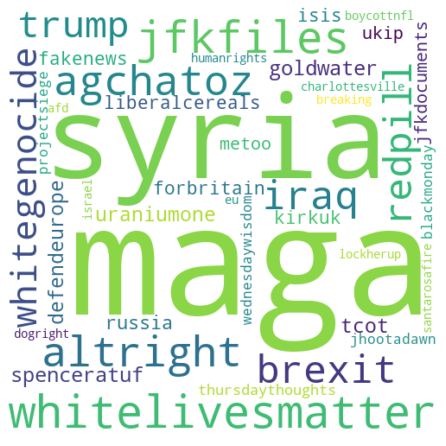

In [0]:
wcloud = WordCloud(width = 500, height = 500,
                background_color ='white', 
                stopwords = stop_words).generate_from_frequencies(hateful_counter) 
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

# Machine Learing

For this particular dataset, the main machine learning task is to predict whether a twitter user is hateful or normal. 

To this end, I have used the annotated_users dataframe.
First, I began with feature engineering.
After feature engineering, the models that I have tried are:

*   SVM (SVC in particular) for classification
*   AdaBoost with Decision Trees as the base_estimator

For these models, I have used GridSearchCV to tune the hyperparameters.

I also used TSNE, K-Means and Hierarchial Clustering for the gloVe vectors and the empathy features to see if it is possible to segment twitter users. 

Described in more detail below


### Feature Engineering




I sorted the columns into three types:
*   gloVe vectors
*   empath values
*   all other columns


In [11]:
cols = annotated_users.columns
glove = []
empath = []
l = []
for s in cols: 
  if ("glove" not in s) and ("empath" not in s): 
    l.append(s)
  if "glove" in s : 
    glove.append(s)
  if "empath" in s:
    empath.append(s)

print(len(l))
print(len(glove)) 
print(len(empath))

51
600
388


**Dropping non numeric and datetime columns**

Next, I log scaled betweeness as those values are really large

In [0]:
# dropping non numeric and time data
dropped = ['time_diff','time_diff_median','created_at', \
           'c_time_diff', 'c_time_diff_median', 'hashtags']
ann_data = annotated_users.drop(columns=dropped)

# log scale for betweeness 
ann_data['betweenness_log'] = np.log(ann_data['c_betweenness'] + 1)

**Creating labels and features from the dataset**

In [0]:
ann_data['user_label'] = ann_data['hate'] == 'hateful'

In [0]:
labels = ann_data['user_label']
features = ann_data.copy()
features = features.drop(columns=['user_label', 'hate', 'user_id', 'c_betweenness', 'betweenness'])

**OverSampling To Balance Dataset** 

A big problem with this dataset was how imbalanced it was. The proportion of normal users to hateful users was almost 10 times more. 
To fix this, I used a RandomOverSampler with a sampling strategy of 0.75 to balance the proportion of hateful and normal users.

In [15]:
# oversampling the hate datapoints
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=0.75)
X_over, y_over = oversample.fit_resample(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Creating x_train, x_test, y_train, y_test from features and labels**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(\
  X_over, y_over, test_size=0.20) 

### **Clustering Algorithms** 

## Hierarchial Clustering for all glove vectors for annotated users

I made a dendogram to pick the number of clusters. Looking at the tallest vertical line (the blue line), we see that the red line at y = 3 shows that there could be between 5-7 clusters.

After trying all three values, n_cluster = 5 gave the best results

In [0]:
glove_df = annotated_users[glove]

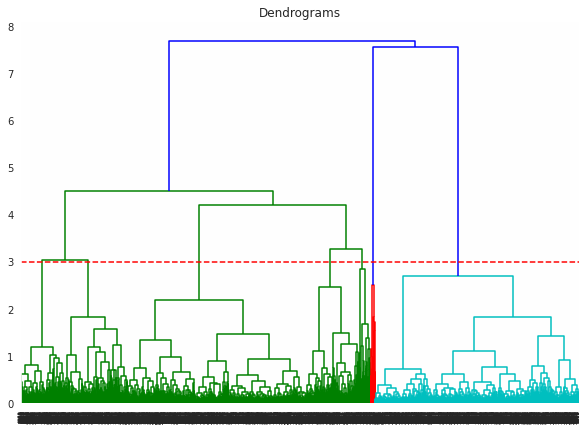

In [0]:
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

data_scaled = normalize(glove_df)
data_scaled = pd.DataFrame(data_scaled, columns=glove_df.columns)

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=3, color='r', linestyle='--') 

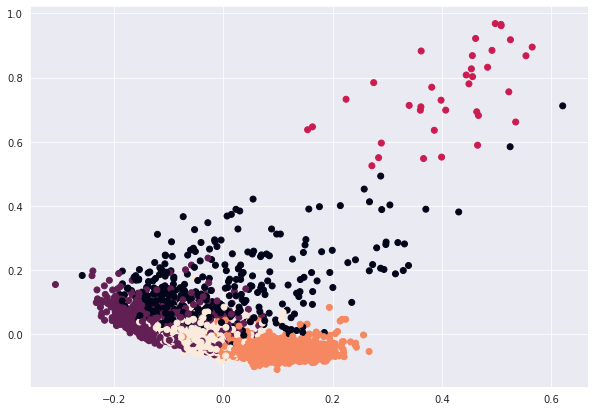

In [0]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
pca = PCA(n_components=2).fit(data_scaled)
Coords = pca.transform(data_scaled)
cluster.fit_predict(data_scaled)
plt.figure(figsize=(10, 7))  
plt.scatter(Coords[:,0], Coords[:,1], c=cluster.labels_) 

I applied pca(n_components = 2) before plotting the clusters. There is still significant overlap between clusters.

## TSNE

Again, I tried tsne for the glove_df. Here, I colored the data points by whether they were hateful or normal users.

TSNE looks at the similarity measure between pairs of instances in high dimensional spaces and in the low dimensional space and optimizes two similarity measures using a cost function. 



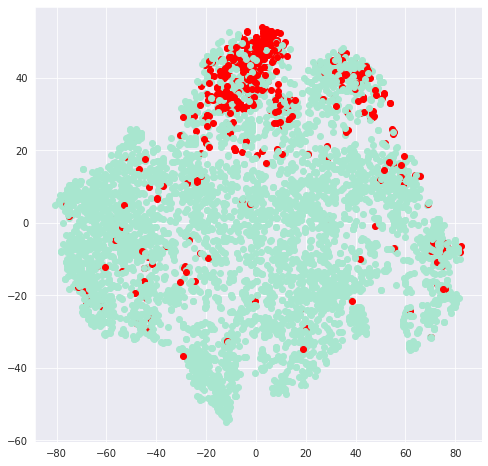

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(glove_df)

new_values = tsne.fit_transform(glove_df)
x = []
y = []
for value in new_values:
  x.append(value[0])
  y.append(value[1])
labels_list = list(labels)  

cmap = {True: 'red', False: '#a8e6cf'}
plt.figure(figsize=(8, 8)) 
for i in range(len(x)):
  plt.scatter(x[i],y[i], color=cmap[labels_list[i]])
  
plt.show()

This is really interesting !!! The hateful users, in red, are all quite close to each other, which suggests that they are similar.

## K-means clustering for glove df

First, I scaled the dataframe, because K means is sensitive to outliers and large ranges of features. To this end, I used StandardScaler() 
and then used pca to reduce the dimensions.

After this, I used the elbow method to decide the number of clusters. 

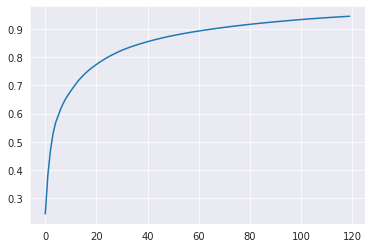

In [0]:
# K means clustering for the glove vectors for 200 tweets for each user
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(glove_df)

pca = PCA(n_components=120)
glove_train = pca.fit_transform(X_std) 
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pc_vs_variance
plt.plot(pc_vs_variance)

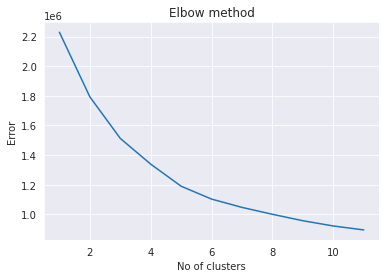

In [0]:
pca = PCA(n_components=25)
glove_train_clustering = pca.fit_transform(X_std) 

Error = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(glove_train_clustering)
    Error.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(1, 12), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

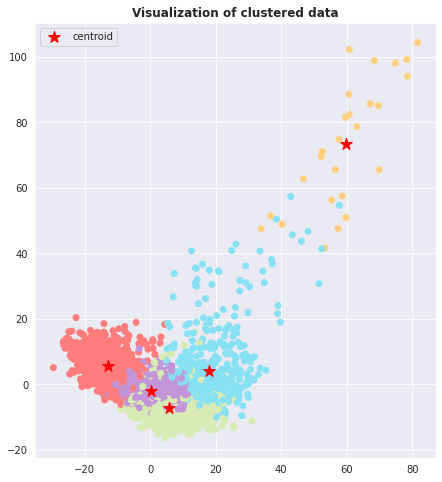

In [0]:
km = KMeans(n_clusters = 5)
y_kmeans = km.fit_predict(glove_train_clustering)

centers = km.cluster_centers_
fig, ax = plt.subplots(figsize=(8, 8))
pca = PCA(n_components=2).fit(X_std)
Coords = pca.transform(X_std) 

sns.set_style("darkgrid")
LABEL_COLOR_MAP = {0 : '#d8ebb5', 1 : '#ff7c7c',  2 : '#ffd082', 3 : '#88e1f2', 4:'#c295d8'}
label_color = [LABEL_COLOR_MAP[l] for l in y_kmeans]
plt.scatter(Coords[:,0], Coords[:,1], c=label_color) 
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=150,
            c='red', label='centroid')
plt.legend()
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal') 
plt.show()

The number of clusters, chosen from the elbow method is 5. The cluster
centers are seen in red, and we see that there is again, siginificant overlap. From what I researched, if there is overlapping between clusters, kmeans doesn’t have an intrinsic measure to determine for which cluster to assign each data point in the overlapping region.

## Clustering for empathy features

Here, I looked at only the empathy features in the annotated_users df and from that, after pre-processing using StandardScaler, used PCA to reduce dimensionality. After that, using the elbow method, I determined the number of clusters to be 4. 
Then, I have plot the clusters. 

In [0]:
empath_2 = []
for s in empath: 
  # if "c_" in s:
  if s.startswith("c_"):
    empath_2.append(s)
print(len(empath_2))

194


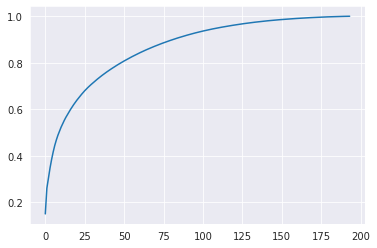

In [0]:
# empath values
empathy_df = annotated_users[empath_2]
X_std_emp = StandardScaler().fit_transform(empathy_df)

pca = PCA(n_components=len(empath_2))
glove_train = pca.fit_transform(X_std_emp) 
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pc_vs_variance
plt.plot(pc_vs_variance)

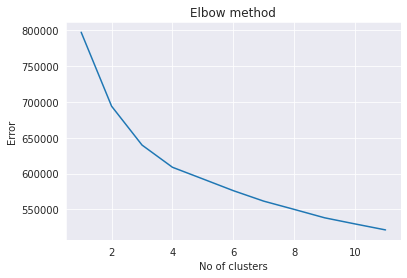

In [0]:
pca = PCA(n_components=75)
empath_train_clustering = pca.fit_transform(X_std_emp) 

Error = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(empath_train_clustering)
    Error.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(1, 12), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

[1 2 0 ... 1 1 1]
<class 'list'>


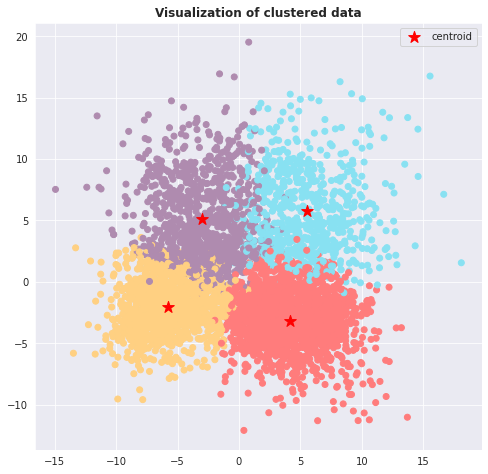

In [0]:
km = KMeans(n_clusters = 4)
y_kmeans_emp = km.fit_predict(empath_train_clustering)
print(y_kmeans_emp)
l = list(range(len(glove)))
print(type(l))

pca = PCA(n_components=2).fit(empath_train_clustering)
Coords = pca.transform(empath_train_clustering) 
centers = km.cluster_centers_
fig, ax = plt.subplots(figsize=(8, 10))

LABEL_COLOR_MAP = {0 : '#af8baf', 1 : '#ff7c7c',  2 : '#ffd082', 3 : '#88e1f2'}
label_color = [LABEL_COLOR_MAP[l] for l in y_kmeans_emp]
plt.scatter(Coords[:,0], Coords[:,1], c=label_color) 
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=150,
            c='r', label='centroid')
plt.legend()
# plt.xlim([-10, 10])
# plt.ylim([-8, 6])
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal')

Here, the clusters visually look more informative than the clustering results from gloVe vectors and so, I went back to the dataset and found the top 5 and bottom 5 average empathy values for each cluster   

In [0]:
empathy_df['emp_cluster_label'] = y_kmeans_emp

In [0]:
cluster_results = empathy_df.groupby(['emp_cluster_label']).mean()
nlargest = 5
order = np.argsort(-cluster_results.values, axis=1)[:, :nlargest]
result = pd.DataFrame(cluster_results.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=cluster_results.index) 
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,top1,top2,top3,top4,top5
emp_cluster_label,,,,,
0,c_politics_empath,c_home_empath,c_ship_empath,c_power_empath,c_negotiate_empath
1,c_valuable_empath,c_art_empath,c_hipster_empath,c_sympathy_empath,c_night_empath
2,c_hipster_empath,c_valuable_empath,c_home_empath,c_dominant_heirarchical_empath,c_occupation_empath
3,c_deception_empath,c_art_empath,c_rural_empath,c_valuable_empath,c_disgust_empath


In [0]:
nsmallest = 5
order = np.argsort(cluster_results.values, axis=1)[:, :nlargest]
result = pd.DataFrame(cluster_results.columns[order], columns=['bottom{}'.format(i) for i in range(1, nlargest+1)],
                      index=cluster_results.index)  
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,bottom1,bottom2,bottom3,bottom4,bottom5
emp_cluster_label,,,,,
0,c_computer_empath,c_achievement_empath,c_suffering_empath,c_celebration_empath,c_listen_empath
1,c_computer_empath,c_achievement_empath,c_violence_empath,c_celebration_empath,c_suffering_empath
2,c_computer_empath,c_suffering_empath,c_military_empath,c_cooking_empath,c_achievement_empath
3,c_suffering_empath,c_computer_empath,c_listen_empath,c_achievement_empath,c_celebration_empath


## **SVC**

Now, to proceed to the machine learning task, using as SVM Classifier.
First, I used PCA to reduce dimensionality and remove multicolinearity
 
Given that SVM is quite sensitive to the scaling for features, I have  used preprocessing.scale to scale the data prior to performing PCA.



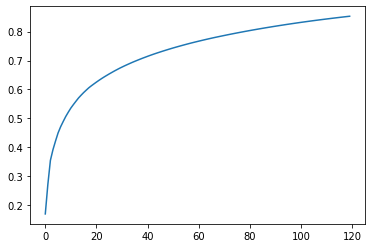

In [17]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

x2_train = preprocessing.scale(x_train)
pca = PCA(n_components=120)
x3_train = pca.fit_transform(x2_train) 
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_) 

pc_vs_variance
plt.plot(pc_vs_variance)

In [0]:
# applying pca = 70% variance
pca = PCA(n_components=80).fit(x2_train)
x_train_transformed = pca.transform(x2_train)
# x_train_transformed = preprocessing.scale(x_train_transformed)

In [0]:
x_test_transformed = preprocessing.scale(x_test)
x_test_transformed = pca.transform(x_test_transformed) 

In [20]:
print(x_train_transformed.shape)
print(x_test_transformed.shape)

(5878, 80)
(1470, 80)


**Performing GridSearch to find the best hyper parameters**

Since I chose rbf as my kernel for SVC, I tuned C and gamma.


In [22]:
# SVM - linear did not work 
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

scores = ['accuracy', 'precision', 'recall']
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid,refit='auc', verbose=1, scoring='accuracy')
grid.fit(x_train_transformed,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.5min finished


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
grid_predictions = grid.predict(x_test_transformed)
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

print("Number of mislabeled points out of a total %d points : %d " % \
      (x_test_transformed.shape[0], (y_test != grid_predictions).sum()))
print("Accuracy:", accuracy_score(y_test, grid_predictions))
print("Precision:", precision_score(y_test, grid_predictions))
print("Recall:", recall_score(y_test, grid_predictions)) 

[[827   0]
 [239 404]]
              precision    recall  f1-score   support

       False       0.78      1.00      0.87       827
        True       1.00      0.63      0.77       643

    accuracy                           0.84      1470
   macro avg       0.89      0.81      0.82      1470
weighted avg       0.87      0.84      0.83      1470

Number of mislabeled points out of a total 1470 points : 239 
Accuracy: 0.8374149659863945
Precision: 1.0
Recall: 0.6283048211508554


Above is the summary of the performance of the SVC classifer



## **AdaBoost with Decision Tree**

Similarly, I used AdaBoost with weak decision tree stumps.
Here I used GridSearch but limited the max depth to be no more than 5.

In [0]:
# Adaboost - takes around 25-30 mins to run
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {"base_estimator__criterion" : ['entropy'],
              'base_estimator__max_depth': [1, 2, 5],
              'n_estimators': [50, 100, 250, 500]
             }

dtclf = DecisionTreeClassifier()
adaBoostclf = AdaBoostClassifier(base_estimator = dtclf)

# run grid search
grid_abc = GridSearchCV(adaBoostclf, param_grid=param_grid, scoring = 'roc_auc', cv=3, verbose=2)
grid_abc.fit(x_train_transformed,y_train)
print(grid_abc.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50, total=   3.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50, total=   3.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50 
[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=50, total=   3.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100 
[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100, total=   6.5s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100 
[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100, total=   6.5s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100 
[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=100, total=   6.4s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=1, n_estimators=250 
[CV]  base_estimator__criterion=entropy, base_estimator__m

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 20.5min finished


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [0]:
# Decision Forest 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

# print(grid_abc.best_estimator_)
grid_abc_predictions = grid_abc.predict(x_test_transformed)
print(confusion_matrix(y_test, grid_abc_predictions))
print(classification_report(y_test, grid_abc_predictions))

print("Number of mislabeled points out of a total %d points : %d " % \
      (x_test_transformed.shape[0], (y_test != grid_abc_predictions).sum()))
print("Accuracy:", accuracy_score(y_test, grid_abc_predictions))
print("Precision:", precision_score(y_test, grid_abc_predictions))
print("Recall:", recall_score(y_test, grid_abc_predictions))

[[802  25]
 [241 402]]
              precision    recall  f1-score   support

       False       0.77      0.97      0.86       827
        True       0.94      0.63      0.75       643

    accuracy                           0.82      1470
   macro avg       0.86      0.80      0.80      1470
weighted avg       0.84      0.82      0.81      1470

Number of mislabeled points out of a total 1470 points : 266 
Accuracy: 0.819047619047619
Precision: 0.9414519906323185
Recall: 0.6251944012441679


Above is the summary of the performance of the AdaBoost classifer


## **Clustering over the entire 100k users empathy**

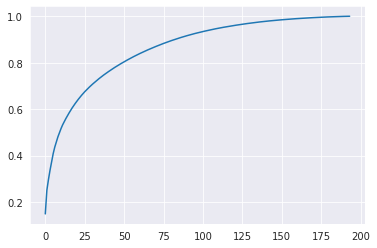

In [0]:
# empath values
all_empathy_df = d[empath_2]
X_std_all_emp = StandardScaler().fit_transform(all_empathy_df)

pca = PCA(n_components=len(empath_2))
glove_train = pca.fit_transform(X_std_all_emp) 
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pc_vs_variance
plt.plot(pc_vs_variance)

In [0]:
print(all_empathy_df.shape)

(92774, 194)


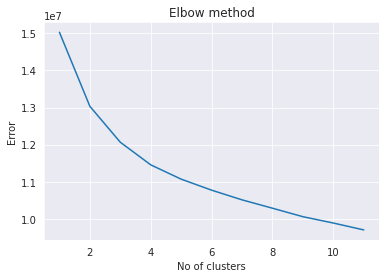

In [0]:
pca = PCA(n_components=60)
empath_all_clustering = pca.fit_transform(X_std_all_emp) 

Error = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(empath_all_clustering)
    Error.append(kmeans.inertia_)

plt.plot(range(1, 12), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

[1 2 0 ... 1 1 1]
<class 'list'>


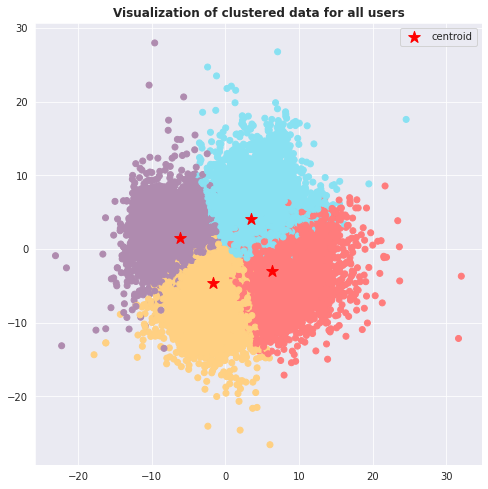

In [0]:
km = KMeans(n_clusters = 4)
y_kmeans_emp_all = km.fit_predict(empath_all_clustering)

pca = PCA(n_components=2).fit(empath_all_clustering)
Coords = pca.transform(empath_all_clustering) 
centers = km.cluster_centers_ 
fig, ax = plt.subplots(figsize=(8, 10))

LABEL_COLOR_MAP = {0 : '#af8baf', 1 : '#ff7c7c',  2 : '#ffd082', 3 : '#88e1f2'}
label_color = [LABEL_COLOR_MAP[l] for l in y_kmeans_emp_all]
plt.scatter(Coords[:,0], Coords[:,1], c=label_color) 
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=150,
            c='r', label='centroid')
plt.legend()
# plt.xlim([-10, 10])
# plt.ylim([-8, 6])
plt.title('Visualization of clustered data for all users', fontweight='bold')
ax.set_aspect('equal') 

In [0]:
all_empathy_df['emp_cluster_label'] = y_kmeans_emp_all

In [0]:
cluster_all_results = all_empathy_df.groupby(['emp_cluster_label']).mean()
nlargest = 5
order = np.argsort(-cluster_all_results.values, axis=1)[:, :nlargest]
result = pd.DataFrame(cluster_all_results.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=cluster_all_results.index)
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,top1,top2,top3,top4,top5
emp_cluster_label,,,,,
0,c_hipster_empath,c_valuable_empath,c_home_empath,c_occupation_empath,c_terrorism_empath
1,c_deception_empath,c_art_empath,c_rural_empath,c_magic_empath,c_disgust_empath
2,c_politics_empath,c_ship_empath,c_home_empath,c_power_empath,c_negotiate_empath
3,c_valuable_empath,c_art_empath,c_deception_empath,c_night_empath,c_hipster_empath


In [0]:
nsmallest = 5
order = np.argsort(cluster_all_results.values, axis=1)[:, :nlargest]
result = pd.DataFrame(cluster_all_results.columns[order], columns=['bottom{}'.format(i) for i in range(1, nlargest+1)],
                      index=cluster_all_results.index)
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,bottom1,bottom2,bottom3,bottom4,bottom5
emp_cluster_label,,,,,
0,c_computer_empath,c_suffering_empath,c_military_empath,c_cooking_empath,c_achievement_empath
1,c_suffering_empath,c_listen_empath,c_computer_empath,c_achievement_empath,c_celebration_empath
2,c_computer_empath,c_achievement_empath,c_suffering_empath,c_celebration_empath,c_listen_empath
3,c_computer_empath,c_achievement_empath,c_suffering_empath,c_celebration_empath,c_toy_empath
